In [19]:
import numpy as np

class AdalineBatchSGD:
    def __init__(self, eta=0.01, n_iter=50, batch_size=20, shuffle=True, random_state=1, tol=0.01 ):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol

    def fit(self, X, y):
        self._initwb(X.shape[1])
        self.losses_ = []

        n_samples = X.shape[0]

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            batch_losses = []
            for start_index in range(0, n_samples, self.batch_size):
                stop_index = start_index + self.batch_size
                X_b, y_b = X[start_index : stop_index], y[start_index : stop_index] 
                outputs = self._activation(self._netinput(X_b))
                errors = y_b - outputs
                self._w += self.eta * 2.0 * X_b.T.dot(errors) / X_b.shape[0]
                self._b += self.eta * 2.0 * errors.mean()
                batch_losses.append(np.mean(errors ** 2))

            avg_loss = np.mean(batch_losses)
            self.losses_.append(avg_loss)
            if avg_loss < self.tol:
                print(f'End of training, converged after {i + 1} iterations.')
                break
        else:
            print(f'End of training, max n of iterations ({self.n_iter}) reached.')    
        return self  
            
    def predict(self, X):
        net_input = self._netinput(X)
        return np.where(net_input >= 0.5, 1, 0)

    def _initwb(self, n_features):
        self._rgen = np.random.default_rng(self.random_state)
        self._w = self._rgen.normal(loc=0.0, scale=0.01, size=n_features)
        self._b = np.float_(0.)

    def _netinput(self, X):
        return X @ self._w + self._b

    def _activation(self, X):
        return X

    def _shuffle(self, X, y):
        p = self._rgen.permutation(len(y))
        return X[p], y[p]

In [20]:
import pandas as pd

df = pd.read_csv('iris.data.csv', header=None, encoding='utf-8')

# Select only Setosa and Versicolor targets
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# Extract sepal and petal length
X = df.iloc[0:100, [0, 2]].values

End of training, converged after 35 iterations.


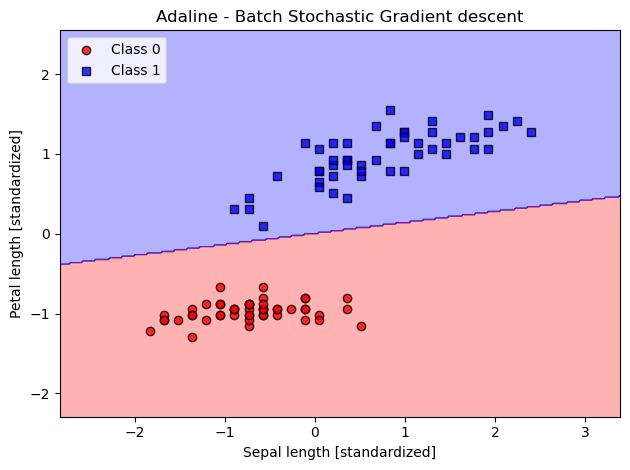

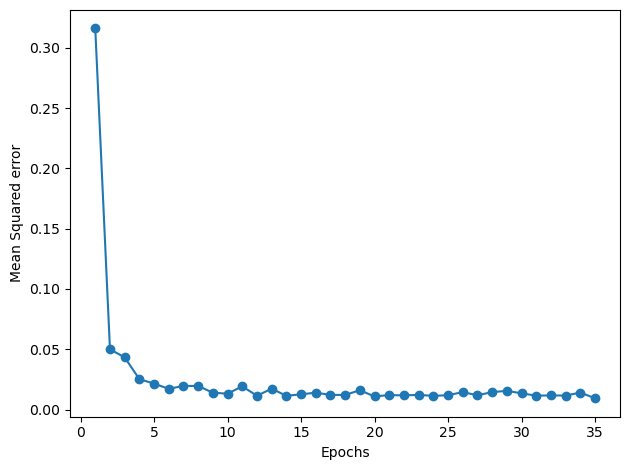

In [25]:
import matplotlib.pyplot as plt

# Make a copy of the dataset with standardized features
X_std = X.copy()
X_std[:,0] = (X_std[:,0] - X_std[:,0].mean()) / X_std[:,0].std()
X_std[:,1] = (X_std[:,1] - X_std[:,1].mean()) / X_std[:,1].std()

# Train the Adaline object
ada_gd = AdalineBatchSGD(eta=0.2, n_iter=40, batch_size=80)
ada_gd.fit(X_std, y)

# Function used to plot the decision boundary
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1 
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1 
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class example
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')


# Make plots
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Batch Stochastic Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.losses_) + 1),
         ada_gd.losses_, 
         marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared error')
plt.tight_layout()
plt.show()